## Phân tích xu hướng sở thích âm nhạc

#### Import các thư viện và các package cần thiết

In [20]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from matplotlib.figure import Figure 
from wordcloud import WordCloud

#### Load dữ liệu

In [ ]:
df_normal  = pd.read_csv('list_info_03.csv') # Load các thông tin các video về âm nhạc thường
# df = pd.read_csv('list_info_trending.csv') # Load thông tin các video về âm nhạc trending
df_normal.head()


In [ ]:
# Xem thông tin tổng quan về data frame
df_normal.info()

In [4]:
# Lọc ra các video âm nhạc tức categoryId là 10 - Music
df_normal = df_normal[df_normal['categoryId']==10]

In [ ]:
# Xử lý các giá trị null trong data frame
df_normal_preprocessed = df_normal.fillna({'description':'', 'tags':'', 'defaultAudioLanguage':'', 'likeCount':0, 'dislikeCount':0, 'commentCount':0, 'topicCategories':'' })
df_normal_preprocessed.head()

In [9]:
# Mô tả các thuộc tính có giá trị nguyên
df_normal.describe()

,categoryId,viewCount,likeCount,dislikeCount,favoriteCount,commentCount
count,3250.0,3.250000e+03,2.742000e+03,0.0,3250.0,3.212000e+03
mean,10.0,7.757448e+06,1.767001e+05,NaN,0.0,1.735291e+04
std,0.0,4.465801e+07,8.834424e+05,NaN,0.0,2.045653e+05
min,10.0,0.000000e+00,0.000000e+00,NaN,0.0,0.000000e+00
25%,10.0,7.630100e+04,1.056250e+03,NaN,0.0,2.100000e+01
50%,10.0,3.032205e+05,4.079500e+03,NaN,0.0,9.400000e+01
75%,10.0,1.666436e+06,3.117650e+04,NaN,0.0,6.162500e+02
max,10.0,1.201917e+09,2.083092e+07,NaN,0.0,8.776885e+06


In [9]:
# Vẽ biểu đồ tròn thống kê theo số view của các video
def pieCharViewCounts(df):
    listVideo_10KView = df[df['viewCount']<100000]['id']
    listVideo_100KView = df[df['viewCount']>=100000][df['viewCount']<1e6]['id']
    listVideo_1MView = df[df['viewCount']>=1e6][df['viewCount']<1e7]['id']
    listVideo_10MView = df[df['viewCount']>=1e7][df['viewCount']<1e8]['id']
    listVideo_100MView = df[df['viewCount']>=1e8][df['viewCount']<1e9]['id']

    y = np.array([len(listVideo_10KView),
                    len(listVideo_100KView),
                    len(listVideo_1MView),
                    len(listVideo_10MView),
                    len(listVideo_100MView),
                ])
    mylabel = ['Video chuc nghin view', 'Video tram nghin view', 'Video trieu view', 'Video chuc trieu view', 'Video tram trieu view']
   
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.pie(y, labels=mylabel)
    plt.show()

C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_100KView = df[df['viewCount']>=100000][df['viewCount']<1e6]['id']
C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_1MView = df[df['viewCount']>=1e6][df['viewCount']<1e7]['id']
C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_10MView = df[df['viewCount']>=1e7][df['viewCount']<1e8]['id']
C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_100MView = df[df['viewCount']>=1e8][df['viewCount']<1e9]['id']


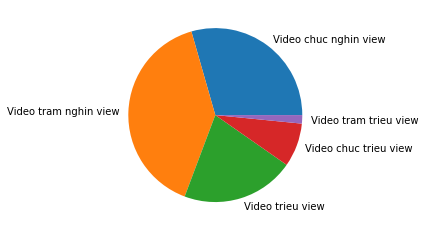

In [10]:
pieCharViewCounts(df_normal)

#### Xử lý tag và tên channel (thêm "_" vào các tag)


In [12]:
df_normal_preprocessed['tags'].fillna('', inplace=True)

In [11]:
def removeSpace(listItems, noise):
    tagsPreprocessed = []
    for item in listItems:
        if item == noise:
            tagsPreprocessed.append(item)
            continue
        item = item.replace(' ','_')
        item = item.replace(',_',', ')
        tagsPreprocessed.append(item)
    # print(tagsPreprocessed)
    return tagsPreprocessed

In [ ]:
print(df_normal_preprocessed['tags'])
tagsPreprocessed = removeSpace(df_normal_preprocessed['tags'], ' ')
# df_normal_preprocessed.drop(columns=['tags'])
# df_normal_preprocessed.assign(tags = tagsPreprocessed)
# print(df_normal_preprocessed['tags'])
# print(tagsPreprocessed)
df_normal_preprocessed['tags'] = tagsPreprocessed

#### Xử lý topic categories

In [15]:
df_normal_preprocessed['topicCategories'] = df_normal['topicCategories'].fillna('')

In [ ]:
listTopics=[]
for index, row in df_normal_preprocessed.iterrows():
    listTopic = row['topicCategories']
    if listTopic == '':
        listTopics.append(listTopic)
        continue
    topicStr = ''
    listTopic = listTopic.replace('https://en.wikipedia.org/wiki/','')
    listTopic = listTopic.replace("'Music'",'')
    listTopic = listTopic.replace(',','')
    listTopic = listTopic.replace('[','')
    listTopic = listTopic.replace(']','')
    listTopic = listTopic.replace('\'','')
    print(listTopic)
    listTopics.append(listTopic)
    #     #topic = topic.removesuffix("https://en.wikipedia.org/wiki/")
    #     print(topic)

print(type(listTopics))

In [ ]:
df_normal_preprocessed['topicCategories'] = listTopics
df_normal_preprocessed

#### Xử lý thời gian 

In [15]:
def convertHour(str):
    if str.find('H') == -1:
        return 0
    hour = str.split('T')[1].split('H')[0]
    return hour

def convertMinute(str):
    if str.find('M') == -1:
        return 0
    if str.find('H') != -1:
        minute = str.split('H')[1].split('M')[0]
    else:
        minute = str.split('T')[1].split('M')[0]
    return minute

def convertSecond(str):
    if str.find('S') == -1:
        return 0
    if str.find('M') == -1:
        if str.find('H') == -1:
            second = str.split('T')[1].split('S')[0]
        else:    
            second = str.split('H')[1].split('S')[0]
    else:
        second = str.split('M')[1].split('S')[0]
    return second

In [16]:
hours, minutes, seconds = [], [], []
years, months, days = [], [], []
durationInt = []
for index, row in df_normal.iterrows():
    hours.append(int(convertHour(row['duration'])))
    minutes.append(int(convertMinute(row['duration'])))
    seconds.append(int(convertSecond(row['duration'])))
    years.append(int(row['publishAt'].split('-',1)[0]))
    months.append(int(row['publishAt'].split('-',1)[1].split('-',1)[0]))
    days.append(int(row['publishAt'].split('-',2)[2].split('T')[0]))
    durationInt.append(hours[-1]*60*60+minutes[-1]*60+seconds[-1])

In [ ]:
df_normal_preprocessed = df_normal_preprocessed.assign(hourDuration=hours, minuteDuration=minutes, secondDuration=seconds, yearPublished=years, monthPublished=months, dayPublished=days, durationInt = durationInt)
df_normal_preprocessed.head()

#### Xử lý tên video 

In [18]:
# Hàm xóa bỏ một số từ gây nhiễu
def removeStopword(texts, stopwords):
    tmpList = []
    for text in texts:
        text = text.lower()
        for stopword in stopwords:
            text = text.replace(stopword,'')
        tmpList.append(text)
    return tmpList

#### Xử lý giá trị các cột về số nguyên

In [21]:
le_captions = preprocessing.LabelEncoder()
le_captions.fit(df_normal['caption'])
df_normal_preprocessed['caption'] = le_captions.transform(df_normal['caption'])

le_embeddables = preprocessing.LabelEncoder()
le_embeddables.fit(df_normal['embeddable'])
df_normal_preprocessed['embeddable'] = le_embeddables.transform(df_normal['embeddable'])

le_madeForKids = preprocessing.LabelEncoder()
le_madeForKids.fit(df_normal['madeForKids'])
df_normal_preprocessed['madeForKids'] = le_madeForKids.transform(df_normal['madeForKids'])

le_privacyStatus = preprocessing.LabelEncoder()
le_privacyStatus.fit(df_normal['privacyStatus'])
df_normal_preprocessed['privacyStatus'] = le_privacyStatus.transform(df_normal['privacyStatus'])

le_definitions = preprocessing.LabelEncoder()
le_definitions.fit(df_normal['definition'])
df_normal_preprocessed['definition'] = le_definitions.transform(df_normal['definition'])

In [ ]:
df_normal_preprocessed.head()

#### Phân tích một số mối quan hệ 

##### Phân phối các video theo số view, like

(array([2.688e+03, 3.000e+01, 1.400e+01, 4.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([       0. ,  2083092.5,  4166185. ,  6249277.5,  8332370. ,
        10415462.5, 12498555. , 14581647.5, 16664740. , 18747832.5,
        20830925. ]),
 <BarContainer object of 10 artists>)

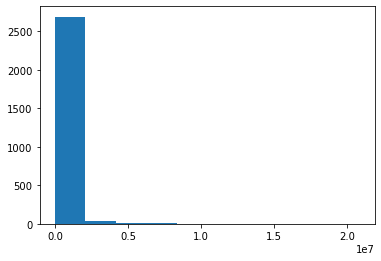

In [23]:
plt.hist(df_normal['likeCount'])

(array([1758.,  186.,  103.,   58.,   61.,   36.,   37.,   32.,   19.,
          20.]),
 array([    0. ,  9994.1, 19988.2, 29982.3, 39976.4, 49970.5, 59964.6,
        69958.7, 79952.8, 89946.9, 99941. ]),
 <BarContainer object of 10 artists>)

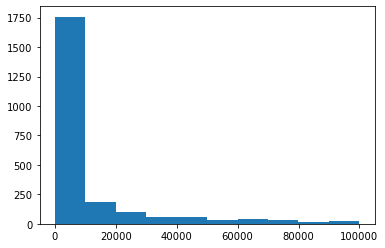

In [24]:
plt.hist(df_normal[df_normal['likeCount']<1e5]['likeCount'])

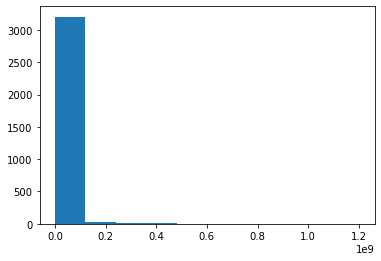

In [25]:
plt.hist(df_normal['viewCount']);

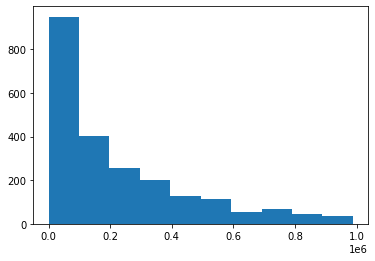

In [26]:
plt.hist(df_normal[df_normal['viewCount']<1e6]['viewCount']);

(array([3.09e+03, 1.09e+02, 6.00e+00, 4.00e+00, 5.00e+00, 1.00e+00,
        4.00e+00, 3.00e+00, 3.00e+00, 2.50e+01]),
 array([    0. ,  8637.9, 17275.8, 25913.7, 34551.6, 43189.5, 51827.4,
        60465.3, 69103.2, 77741.1, 86379. ]),
 <BarContainer object of 10 artists>)

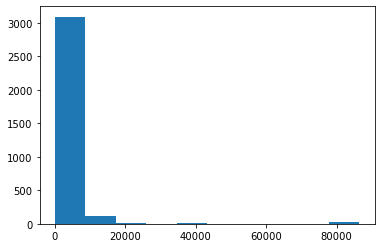

In [27]:
plt.hist(df_normal_preprocessed['durationInt'])

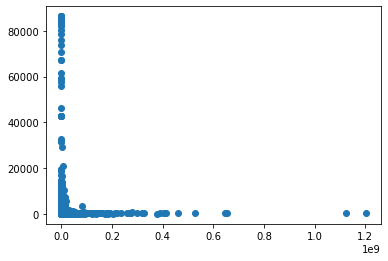

In [28]:
plt.scatter(df_normal_preprocessed['viewCount'], df_normal_preprocessed['durationInt'])

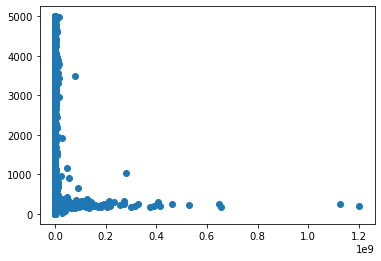

In [29]:
plt.scatter(df_normal_preprocessed[ df_normal_preprocessed['durationInt']<5e3]['viewCount'], df_normal_preprocessed[ df_normal_preprocessed['durationInt']<5e3]['durationInt'])

C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/1613510240.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_normal_preprocessed[ df_normal_preprocessed['durationInt']<5e3][df_normal_preprocessed['viewCount']<1e7]['viewCount'], df_normal_preprocessed[ df_normal_preprocessed['durationInt']<5e3][df_normal_preprocessed['viewCount']<1e7]['durationInt'])


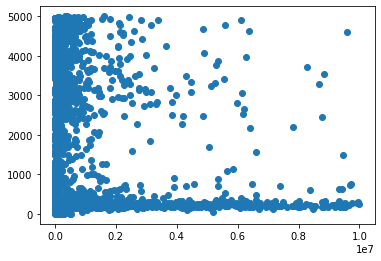

In [30]:

plt.scatter(df_normal_preprocessed[ df_normal_preprocessed['durationInt']<5e3][df_normal_preprocessed['viewCount']<1e7]['viewCount'], df_normal_preprocessed[ df_normal_preprocessed['durationInt']<5e3][df_normal_preprocessed['viewCount']<1e7]['durationInt'])

##### Quan hệ giữa các thuộc tính

In [ ]:
corr = df_normal_preprocessed.corr()
print(df_normal_preprocessed.head(5))

In [32]:
df_normal_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3250 entries, 0 to 4960
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    3250 non-null   object 
 1   publishAt             3250 non-null   object 
 2   title                 3250 non-null   object 
 3   description           3250 non-null   object 
 4   channelTitle          3250 non-null   object 
 5   tags                  3250 non-null   object 
 6   categoryId            3250 non-null   int64  
 7   defaultAudioLanguage  3250 non-null   object 
 8   duration              3250 non-null   object 
 9   dimension             3250 non-null   object 
 10  definition            3250 non-null   int32  
 11  caption               3250 non-null   int64  
 12  privacyStatus         3250 non-null   int32  
 13  embeddable            3250 non-null   int64  
 14  madeForKids           3250 non-null   int64  
 15  viewCount            

<AxesSubplot:>

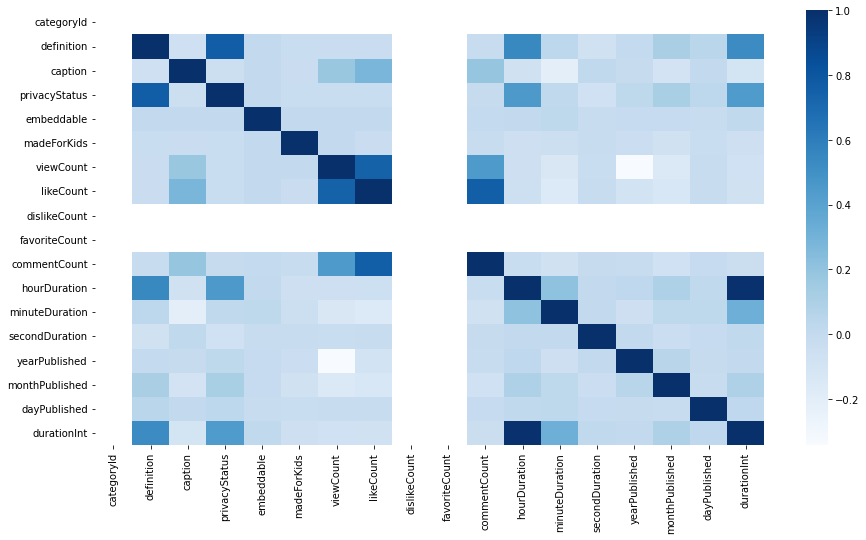

In [33]:
plt.figure(figsize=(15,8))
heatmap_df_normal_preprocess = df_normal_preprocessed[['viewCount','likeCount','dislikeCount','commentCount', 'favoriteCount']]
corr = df_normal_preprocessed.corr()
sns.heatmap(corr, cmap='Blues')

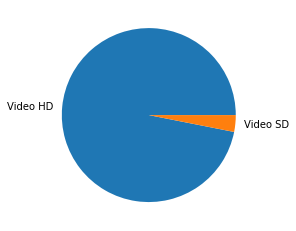

In [64]:
# plt.figure(figsize=(8,16))

# plt.scatter(df_normal_preprocessed['definition'], df_normal_preprocessed['viewCount'])
# plt.title('View count - Definition')
# plt.xlabel('Definition')
# plt.ylabel('View count')

hd_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==0]
sd_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==1]

y = np.array([hd_videos.shape[0], sd_videos.shape[0]])
mylabel = ['Video HD', 'Video SD']
   
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie(y, labels=mylabel)
plt.show()

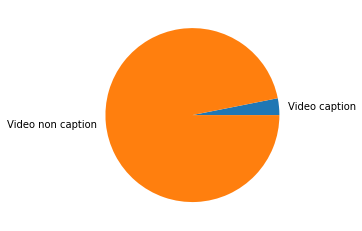

In [67]:
# plt.scatter(df_normal_preprocessed['caption'], df_normal_preprocessed['viewCount'])
# plt.title('View count - Caption')
# plt.xlabel('Caption')
# plt.ylabel('View count')

df_normal['caption'].unique()

caption_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==1]
non_caption_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==0]

y = np.array([caption_videos.shape[0], non_caption_videos.shape[0]])
mylabel = ['Video caption', 'Video non caption']
   
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie(y, labels=mylabel)
plt.show()

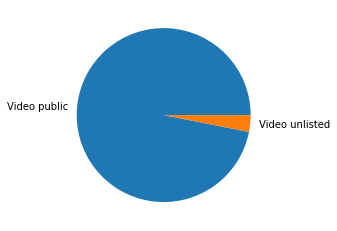

In [69]:
# plt.scatter(df_normal_preprocessed['privacyStatus'], df_normal_preprocessed['viewCount'])
# plt.title('View count - Definition')
# plt.xlabel('Definition')
# plt.ylabel('View count')

df_normal['privacyStatus'].unique()

public_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==0]
unlisted_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==1]

y = np.array([public_videos.shape[0], unlisted_videos.shape[0]])
mylabel = ['Video public', 'Video unlisted']
   
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie(y, labels=mylabel)
plt.show()

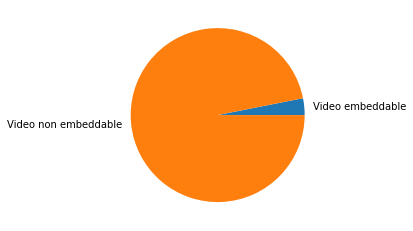

In [71]:
# plt.scatter(df_normal_preprocessed['embeddable'], df_normal_preprocessed['viewCount'])
# plt.title('View count - Definition')
# plt.xlabel('Definition')
# plt.ylabel('View count')

# df_normal['embeddable'].unique()

embeddable_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==1]
non_embeddable_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==0]

y = np.array([embeddable_videos.shape[0], non_embeddable_videos.shape[0]])
mylabel = ['Video embeddable', 'Video non embeddable']
   
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie(y, labels=mylabel)
plt.show()

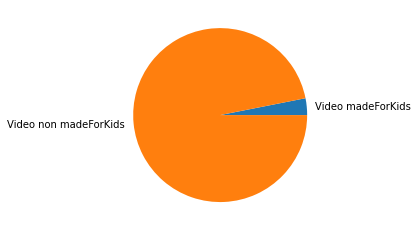

In [75]:
# plt.scatter(df_normal_preprocessed['madeForKids'], df_normal_preprocessed['viewCount'])
# plt.title('View count - Definition')
# plt.xlabel('Definition')
# plt.ylabel('View count')

# df_normal['madeForKids'].unique()
# test = df_normal[df_normal['madeForKids']==False]
madeForKids_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==1]
non_madeForKids_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==0]

y = np.array([madeForKids_videos.shape[0], non_madeForKids_videos.shape[0]])
mylabel = ['Video madeForKids', 'Video non madeForKids']
   
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie(y, labels=mylabel)
plt.show()

#### Chuyển text thành vector IF TDF

In [34]:
def convertIfTdf(df, column, stopwords):
    data_train = df[column]
    data_train = removeStopword(data_train, stopwords)

    module_count_vector = TfidfVectorizer(stop_words=stopwords)
    model_rf_preprocess = Pipeline([('vect', module_count_vector),
                        ('tfidf', TfidfTransformer()),
                        ])
    # Hàm thực hiện chuyển đổi dữ liệu text thành dữ liệu số dạng ma trận 
    # Input: Dữ liệu 2 chiều dạng numpy.array, mảng nhãn id dạng numpy.array 
    data_preprocessed = module_count_vector.fit_transform(data_train)

    print(f"\nSố lượng từ trong từ điển: {len(module_count_vector.vocabulary_)}")
    print(f"Kích thước dữ liệu sau khi xử lý: {data_preprocessed.shape}")
    print(f"Xem các từ trong từ điển: {module_count_vector.vocabulary_}")
    print(type(data_preprocessed))
    return data_preprocessed


In [ ]:
stopwords = [ 'official', 'mv', 'video', 'music', 'nhạc', 'âm', 'hát', 'tuyển', 'tập', 'bài', 'những', 'ca', ' x ', 'ft','feat']
X = convertIfTdf(df_normal_preprocessed,'title', stopwords)
print(type(X))

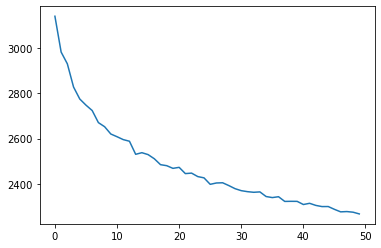

In [37]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
loss = []
for i in range(50):
    i = i + 1
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    loss.append(kmeans.inertia_)
plt.plot(range(50), loss)

In [97]:
clustering = KMeans(n_clusters=10,init='k-means++', random_state=0).fit(X)
clustering.cluster_centers_

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00209965, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [98]:
label = clustering.labels_
print(label.shape)
for i in label:
    print(i)

(3250,)
5
6
6
6
3
6
6
6
6
6
6
6
8
6
6
6
6
6
6
6
6
6
6
5
6
6
6
6
6
6
6
6
8
6
6
6
6
5
6
6
6
3
6
6
6
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
3
6
6
6
5
8
8
6
6
5
6
6
8
6
6
6
6
8
6
3
6
6
6
8
6
6
6
8
8
3
6
6
3
6
6
6
6
8
6
8
6
6
6
6
6
6
6
6
1
1
1
1
6
1
5
6
1
5
9
5
5
5
7
4
1
5
1
1
1
6
1
6
5
1
2
5
4
1
4
5
4
1
1
1
1
6
1
5
5
9
5
6
7
6
6
1
7
6
6
1
5
7
8
6
6
6
6
2
6
1
5
1
6
6
1
6
1
1
6
1
6
7
6
9
2
1
4
5
6
8
6
6
1
2
8
5
1
6
6
1
6
6
1
1
6
6
6
1
4
8
6
6
8
1
9
8
6
1
1
6
5
6
6
6
5
6
6
7
4
5
6
6
1
2
8
6
6
1
6
1
1
5
5
2
6
7
6
5
6
5
8
8
6
6
2
6
6
6
1
6
6
1
1
8
6
1
6
1
6
6
5
6
5
5
1
1
6
6
6
8
1
6
6
6
6
6
8
6
5
5
6
6
1
6
6
1
6
1
1
6
6
1
6
1
6
6
5
6
6
6
1
5
6
1
8
6
5
6
6
1
6
1
6
8
6
6
8
8
6
6
8
6
6
1
6
8
6
6
6
6
1
1
6
6
1
6
1
6
1
6
1
1
8
6
8
6
6
1
8
8
8
6
8
8
1
8
8
6
6
6
6
8
8
6
6
8
8
8
8
6
6
8
8
6
6
8
5
6
6
6
8
6
6
6
8
8
8
8
6
6
8
8
8
6
6
6
6
6
6
6
6
6
6
6
6
6
0
2
2
0
0
5
0
6
0
0
0
0
6
5
6
0
6
5
0
0
0
0
0
0
5
0
4
0
4
4
0
0
0
4
9
0
6
0
6
0
2
4
0
4
4
4
0
0
4
4
0
0
4
0
4
0
0
9
0
2
4
0
0
5
5
9
9
0
0


In [99]:
temp_df = df_normal_preprocessed.assign(label=label)
temp_df = temp_df.assign(topics = listTopics)
temp_df.info()

for i in range(len(np.unique(label))):
    print(i)
    filter_df = temp_df[label==i]
    filter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3250 entries, 0 to 4960
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    3250 non-null   object 
 1   publishAt             3250 non-null   object 
 2   title                 3250 non-null   object 
 3   description           3250 non-null   object 
 4   channelTitle          3250 non-null   object 
 5   tags                  3250 non-null   object 
 6   categoryId            3250 non-null   int64  
 7   defaultAudioLanguage  3250 non-null   object 
 8   duration              3250 non-null   object 
 9   dimension             3250 non-null   object 
 10  definition            3250 non-null   int32  
 11  caption               3250 non-null   int64  
 12  privacyStatus         3250 non-null   int32  
 13  embeddable            3250 non-null   int64  
 14  madeForKids           3250 non-null   int64  
 15  viewCount            

In [100]:
def drawWordCloud(df, column, stopwords):
  for i in range(len(np.unique(label))):
      
      #Extract cleaned text column
      data=df[df['label']==i][column].values
      data = removeStopword(data, stopwords)
      list_of_words=[];
      for sent in data:
        if type(sent)!=str:
          continue
        for word in sent.split():
          list_of_words.append(word)  
      final_text=" ".join(list_of_words)
      wordcloud = WordCloud(collocations=False).generate(final_text)
      plt.figure()
      title="\nCluster : "+str(i+1)+"\n Number of Videos : "+str(len(data))
      plt.title(title)
      plt.imshow(wordcloud, interpolation="bilinear")
      plt.axis("off")
      plt.show()
      print(wordcloud.words_)



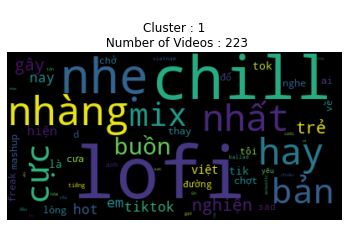

{'lofi': 1.0, 'chill': 0.6504065040650406, 'nhẹ': 0.4065040650406504, 'nhàng': 0.4065040650406504, 'hay': 0.34146341463414637, 'nhất': 0.3394308943089431, 'bản': 0.29878048780487804, 'cực': 0.2804878048780488, 'mix': 0.25609756097560976, 'buồn': 0.21544715447154472, 'nghiện': 0.19715447154471544, 'gây': 0.1951219512195122, 'trẻ': 0.18699186991869918, 'em': 0.12601626016260162, 'tiktok': 0.11178861788617886, 'hot': 0.10569105691056911, 'nay': 0.1016260162601626, 'hiện': 0.09349593495934959, 'việt': 0.08536585365853659, 'là': 0.07113821138211382, 'tik': 0.07113821138211382, 'tok': 0.07113821138211382, 'thay': 0.06300813008130081, 'lòng': 0.06300813008130081, 'cưa': 0.06300813008130081, 'đổ': 0.06300813008130081, 'mashup': 0.06300813008130081, 'chợt': 0.06097560975609756, 'ai': 0.05894308943089431, 'freak': 0.05894308943089431, 'd': 0.05894308943089431, 'nghe': 0.054878048780487805, 'đường': 0.04878048780487805, 'tôi': 0.04878048780487805, 'chở': 0.04878048780487805, 'về': 0.0487804878048

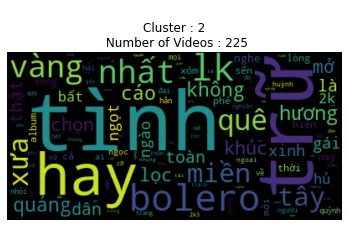

{'tình': 1.0, 'trữ': 0.9222614840989399, 'hay': 0.6784452296819788, 'bolero': 0.6431095406360424, 'lk': 0.6219081272084805, 'nhất': 0.4628975265017668, 'vàng': 0.43109540636042404, 'quê': 0.36395759717314485, 'xưa': 0.3392226148409894, 'miền': 0.3250883392226148, 'tây': 0.3215547703180212, 'hương': 0.31802120141342755, 'không': 0.29328621908127206, 'quảng': 0.29328621908127206, 'cáo': 0.28975265017667845, 'khúc': 0.254416961130742, 'chọn': 0.254416961130742, 'lọc': 0.24734982332155478, 'mở': 0.2226148409893993, 'thật': 0.2226148409893993, 'là': 0.2049469964664311, 'toàn': 0.2049469964664311, 'dân': 0.2049469964664311, 'gái': 0.18021201413427562, 'xinh': 0.17667844522968199, 'ngọt': 0.16607773851590105, 'ngào': 0.16607773851590105, '2k': 0.14840989399293286, 'bất': 0.14487632508833923, 'hủ': 0.14487632508833923, 'nghe': 0.0706713780918728, 'sến': 0.05653710247349823, 'album': 0.053003533568904596, 'hiện': 0.04946996466431095, 'nay': 0.04946996466431095, 'phê': 0.045936395759717315, 'son

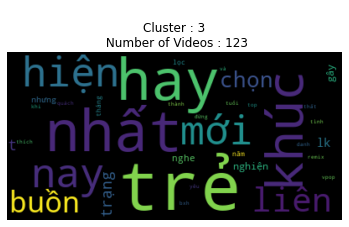

{'trẻ': 1.0, 'hay': 0.6713091922005571, 'nhất': 0.6685236768802229, 'khúc': 0.5153203342618384, 'hiện': 0.32590529247910865, 'nay': 0.32590529247910865, 'mới': 0.3147632311977716, 'liên': 0.31197771587743733, 'buồn': 0.23119777158774374, 'chọn': 0.116991643454039, 't': 0.04178272980501393, 'trạng': 0.04178272980501393, 'lk': 0.022284122562674095, 'gây': 0.016713091922005572, 'nghiện': 0.016713091922005572, 'nghe': 0.013927576601671309, 'nhưng': 0.011142061281337047, 'lọc': 0.005571030640668524, 'năm': 0.005571030640668524, 'tháng': 0.005571030640668524, 'quách': 0.002785515320334262, 'thành': 0.002785515320334262, 'danh': 0.002785515320334262, 'yêu': 0.002785515320334262, 'thích': 0.002785515320334262, 'vpop': 0.002785515320334262, 'top': 0.002785515320334262, 'tuổi': 0.002785515320334262, 'remix': 0.002785515320334262, 'đừng': 0.002785515320334262, 'khi': 0.002785515320334262, 'thất': 0.002785515320334262, 'tình': 0.002785515320334262, 'và': 0.002785515320334262, 'bxh': 0.002785515320

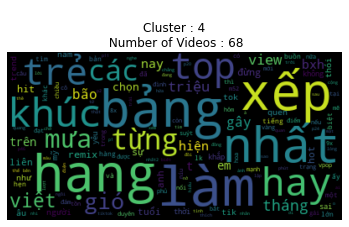

{'làm': 1.0, 'bảng': 0.8636363636363636, 'xếp': 0.8636363636363636, 'hạng': 0.8636363636363636, 'nhất': 0.7727272727272727, 'khúc': 0.7575757575757576, 'hay': 0.7272727272727273, 'top': 0.696969696969697, 'trẻ': 0.6818181818181818, 'từng': 0.6515151515151515, 'các': 0.6363636363636364, 'mưa': 0.5151515151515151, 'gió': 0.5, 'việt': 0.36363636363636365, 'tháng': 0.19696969696969696, 'triệu': 0.18181818181818182, 'view': 0.18181818181818182, 'gây': 0.16666666666666666, 'bão': 0.16666666666666666, 'bxh': 0.15151515151515152, 'hiện': 0.15151515151515152, 'nay': 0.15151515151515152, 't': 0.13636363636363635, 'trên': 0.13636363636363635, 'em': 0.13636363636363635, 'chọn': 0.12121212121212122, 'sự': 0.10606060606060606, 'đừng': 0.10606060606060606, 'remix': 0.10606060606060606, 'hit': 0.10606060606060606, 'tuổi': 0.09090909090909091, 'liên': 0.09090909090909091, 'anh': 0.09090909090909091, 'hot': 0.09090909090909091, 'nam': 0.07575757575757576, 'người': 0.07575757575757576, 'như': 0.075757575

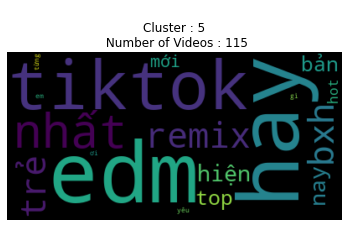

{'hay': 1.0, 'edm': 0.9956521739130435, 'tiktok': 0.9956521739130435, 'nhất': 0.9956521739130435, 'remix': 0.5043478260869565, 'bxh': 0.5, 'trẻ': 0.5, 'hiện': 0.5, 'nay': 0.5, 'top': 0.4956521739130435, 'bản': 0.4956521739130435, 'mới': 0.30434782608695654, 'hot': 0.19130434782608696, 'em': 0.004347826086956522, 'gì': 0.004347826086956522, 'ơi': 0.004347826086956522, 'từng': 0.004347826086956522, 'yêu': 0.004347826086956522}


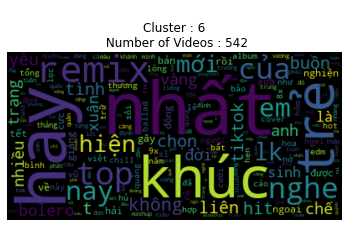

{'nhất': 1.0, 'hay': 0.8957528957528957, 'khúc': 0.5598455598455598, 'trẻ': 0.5135135135135135, 'remix': 0.2953667953667954, 'top': 0.21042471042471042, 'nghe': 0.1969111969111969, 'của': 0.1969111969111969, 'nay': 0.1891891891891892, 'em': 0.17953667953667954, 'lk': 0.16023166023166024, 'mới': 0.15057915057915058, 'hiện': 0.14671814671814673, 'không': 0.14092664092664092, 'hit': 0.13320463320463322, 'liên': 0.1274131274131274, 'buồn': 0.1274131274131274, 'chọn': 0.1274131274131274, 'yêu': 0.12548262548262548, 't': 0.12355212355212356, 'tình': 0.11969111969111969, 'tiktok': 0.11969111969111969, 'bolero': 0.10617760617760617, 'trạng': 0.10424710424710425, 'anh': 0.10231660231660232, 'vàng': 0.09845559845559845, 'nhiều': 0.09652509652509653, 'chế': 0.0945945945945946, 'đời': 0.0945945945945946, 'xuân': 0.0888030888030888, 'là': 0.08108108108108109, 'sinh': 0.08108108108108109, 'nghiện': 0.07915057915057915, 'được': 0.07915057915057915, 'hải': 0.07528957528957529, 'ngoại': 0.0752895752895

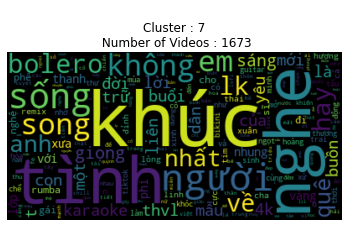

{'khúc': 1.0, 'tình': 0.7040816326530612, 'nghe': 0.6938775510204082, 'người': 0.6887755102040817, 'sống': 0.6020408163265306, 'không': 0.5153061224489796, 'song': 0.5051020408163265, 'em': 0.49489795918367346, 'bolero': 0.45918367346938777, 'lk': 0.4336734693877551, 'hay': 0.42346938775510207, 'về': 0.40816326530612246, 'anh': 0.37755102040816324, 'nhất': 0.37244897959183676, 'quê': 0.35714285714285715, 'giọng': 0.3520408163265306, 'sáng': 0.3469387755102041, 'đời': 0.32653061224489793, 'buồn': 0.3112244897959184, 'là': 0.3010204081632653, 'lời': 0.2857142857142857, 'thvl': 0.2857142857142857, 'con': 0.2755102040816326, 'karaoke': 0.27040816326530615, 'mẫu': 0.2653061224489796, 'buổi': 0.2653061224489796, 'mới': 0.2602040816326531, 'của': 0.2602040816326531, 'trữ': 0.2602040816326531, 'yêu': 0.25, 'liên': 0.25, 't': 0.24489795918367346, 'dân': 0.23979591836734693, '4k': 0.23979591836734693, 'một': 0.23469387755102042, 'nhung': 0.23469387755102042, 'thanh': 0.22448979591836735, 'với': 

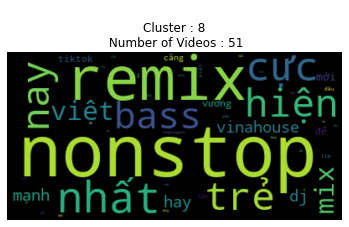

{'nonstop': 1.0, 'remix': 0.6847826086956522, 'nhất': 0.5869565217391305, 'cực': 0.532608695652174, 'trẻ': 0.4891304347826087, 'hiện': 0.4891304347826087, 'nay': 0.4891304347826087, 'bass': 0.4891304347826087, 'việt': 0.44565217391304346, 'mix': 0.44565217391304346, 'vinahouse': 0.44565217391304346, 'hay': 0.43478260869565216, 'mạnh': 0.43478260869565216, 'dj': 0.43478260869565216, 'mới': 0.15217391304347827, 'vương': 0.11956521739130435, 'đế': 0.10869565217391304, 'tiktok': 0.10869565217391304, 'căng': 0.09782608695652174, 'sàn': 0.043478260869565216, 'biết': 0.03260869565217391, 'tìm': 0.03260869565217391, 'đâu': 0.03260869565217391, 'dunghoangpham': 0.010869565217391304, 'một': 0.010869565217391304, 'bậc': 0.010869565217391304, 'quân': 0.010869565217391304, 'áo': 0.010869565217391304, 'cũ': 0.010869565217391304, 'tình': 0.010869565217391304, 'em': 0.010869565217391304, 'thay': 0.010869565217391304, 'lòng': 0.010869565217391304, 'hot': 0.010869565217391304, 'tik': 0.01086956521739130

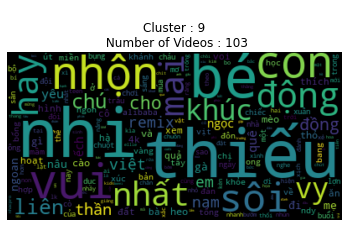

{'nhi': 1.0, 'thiếu': 0.9922480620155039, 'bé': 0.7364341085271318, 'vui': 0.4728682170542636, 'nhộn': 0.4418604651162791, 'con': 0.40310077519379844, 'sôi': 0.32558139534883723, 'động': 0.32558139534883723, 'hay': 0.3178294573643411, 'mai': 0.3023255813953488, 'nhất': 0.29457364341085274, 'khúc': 0.29457364341085274, 'vy': 0.2868217054263566, 'liên': 0.24031007751937986, 'chú': 0.2248062015503876, 'cho': 0.16279069767441862, 'đồng': 0.13953488372093023, 'thần': 0.12403100775193798, 'em': 0.10852713178294573, 'việt': 0.10852713178294573, 'nam': 0.10852713178294573, 'remix': 0.10852713178294573, 'quê': 0.06976744186046512, 'yêu': 0.06976744186046512, 'ếch': 0.06201550387596899, 'ngọc': 0.06201550387596899, 'ngoan': 0.05426356589147287, 'gà': 0.05426356589147287, 'nâu': 0.05426356589147287, 'mẹ': 0.05426356589147287, 'đi': 0.05426356589147287, 'heo': 0.046511627906976744, 'gì': 0.046511627906976744, 'và': 0.046511627906976744, 'cào': 0.046511627906976744, 'thỏ': 0.046511627906976744, 'mè

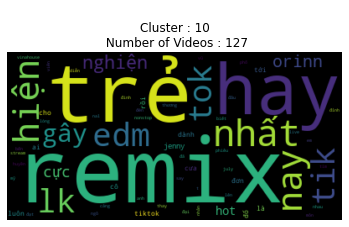

{'remix': 1.0, 'trẻ': 0.8369565217391305, 'hay': 0.5942028985507246, 'nhất': 0.4927536231884058, 'hiện': 0.4528985507246377, 'nay': 0.4528985507246377, 'edm': 0.4492753623188406, 'lk': 0.4384057971014493, 'tik': 0.4311594202898551, 'tok': 0.4311594202898551, 'gây': 0.42028985507246375, 'nghiện': 0.42028985507246375, 'orinn': 0.33695652173913043, 'cực': 0.27898550724637683, 'hot': 0.16666666666666666, 'jenny': 0.043478260869565216, 'cưa': 0.036231884057971016, 'là': 0.036231884057971016, 'đổ': 0.036231884057971016, 'rồi': 0.036231884057971016, 'tới': 0.036231884057971016, 'luôn': 0.03260869565217391, 'tiktok': 0.028985507246376812, 'cô': 0.025362318840579712, 'đơn': 0.025362318840579712, 'dành': 0.025362318840579712, 'cho': 0.025362318840579712, 'ai': 0.025362318840579712, 'mỹ': 0.0036231884057971015, 'nhân': 0.0036231884057971015, 'đinh': 0.0036231884057971015, 'đại': 0.0036231884057971015, 'vũ': 0.0036231884057971015, 'căng': 0.0036231884057971015, 'nal': 0.0036231884057971015, 'biết'

In [101]:
drawWordCloud(temp_df,'title', stopwords)

0


C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_100KView = df[df['viewCount']>=100000][df['viewCount']<1e6]['id']
C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_1MView = df[df['viewCount']>=1e6][df['viewCount']<1e7]['id']
C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_10MView = df[df['viewCount']>=1e7][df['viewCount']<1e8]['id']
C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_100MView = df[df['viewCount']>=1e8][df['viewCount']<1e9]['id']


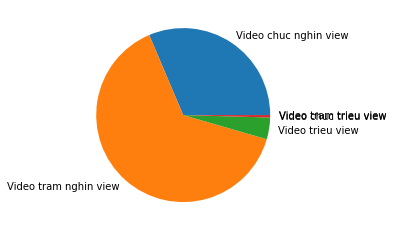

1


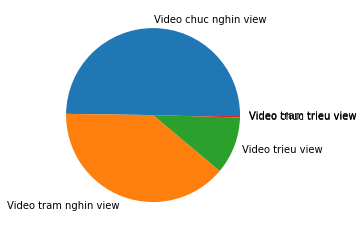

2


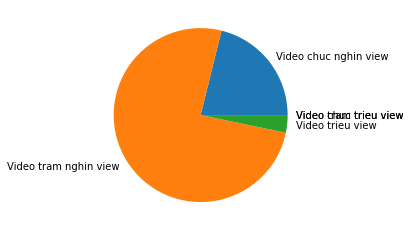

3


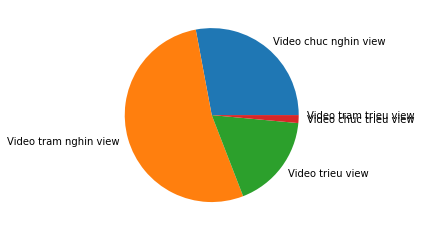

4


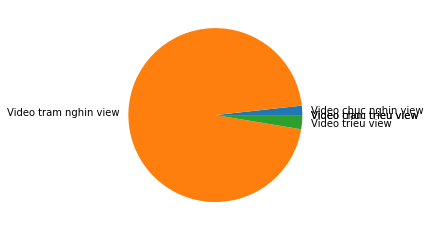

5


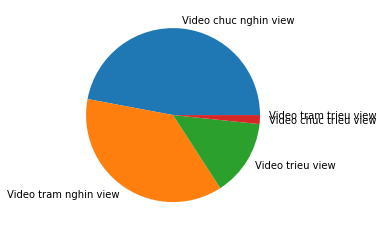

6


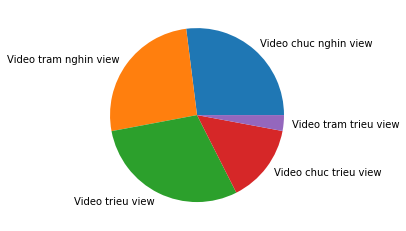

7


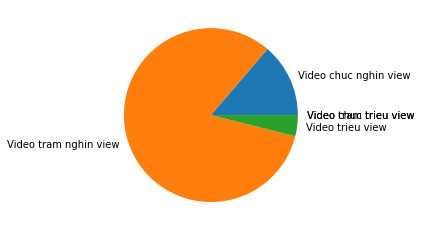

8


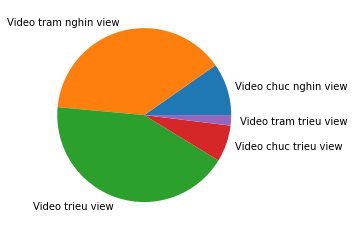

9


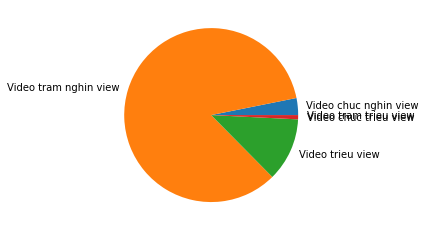

In [80]:
for i in range(len(np.unique(label))):
    print(i)
    pieCharViewCounts(temp_df[temp_df['label']==i])

In [61]:
clustered_df = temp_df.groupby(['label']).sum()

In [67]:
clustered_df[['viewCount', 'likeCount', 'durationInt']]

,viewCount,likeCount,durationInt
label,,,
0,89230736,515148.0,724423
1,118550098,2384239.0,2447635
2,41940541,232354.0,746225
3,53205338,155784.0,461525
4,51183052,447746.0,583905
5,429444263,2714349.0,3205259
6,23534411417,475847929.0,3167148
7,19900713,154324.0,223874
8,782986636,1703104.0,148220


In [81]:
abnormal_cluster = temp_df[temp_df['label']==6]
# abnormal_cluster = abnormal_cluster[abnormal_cluster['label']==2]

In [82]:
stopwords = [ 'official', 'mv', 'video', 'music', 'nhạc', 'âm', 'hát', 'tuyển', 'tập', 'bài', 'những', 'ca', ' x ', 'ft','feat']
X_abnormal = convertIfTdf(abnormal_cluster,'title', stopwords)
print(type(X_abnormal))
kmeans = KMeans(n_clusters=5,init='k-means++', random_state=0).fit(X_abnormal)
kmeans.cluster_centers_

label = kmeans.labels_

print(label.shape)
for i in label:
    print(i)
abnormal_cluster = abnormal_cluster.assign(label = label)


Số lượng từ trong từ điển: 3994
Kích thước dữ liệu sau khi xử lý: (1673, 3994)
Xem các từ trong từ điển: {'top': 3220, 'đang': 3732, 'gây': 1185, 'bão': 414, 'trên': 3269, 'các': 660, 'bxh': 400, 'như': 2219, 'một': 2088, 'người': 2177, 'dưng': 900, 'lạ': 1803, 'thoáng': 3090, 'qua': 2542, 'họa': 1359, 'ức': 3932, 'dratellingmontee': 849, 'prod': 2521, 'tuanuki': 3311, 'animate': 187, 'sino': 2840, 'thư': 3133, 'giãn': 1119, 'tôi': 3362, 'season': 2756, 'nửa': 2319, 'hồn': 1365, 'thương': 3134, 'đau': 3733, 'thanh': 3066, 'lan': 1654, 'liveshow': 1716, 'hải': 1349, 'ngoại': 2156, 'trúc': 3277, 'sinh': 2836, 'entertainment': 952, '60s': 86, 'búp': 431, 'bê': 419, 'trò': 3273, 'chơi': 546, 'con': 606, 'mực': 2094, 'squid': 2911, 'game': 1076, 'nhảy': 2222, 'cực': 718, 'sung': 2954, 'cùng': 678, 'trai': 3232, 'đẹp': 3814, 'rise': 2648, 'above': 122, 'tripledmai': 3247, 'mr': 2017, 'vịt': 3546, 'yomost': 3680, 'vfl': 3464, 'winter': 3604, '2021': 45, 'theme': 3072, 'song': 2881, 'vũ': 352

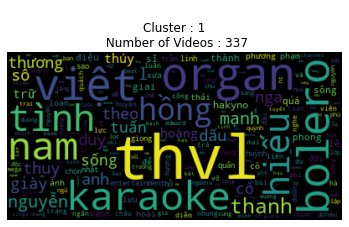

{'thvl': 1.0, 'organ': 0.4888888888888889, 'việt': 0.4444444444444444, 'bolero': 0.4222222222222222, 'karaoke': 0.35555555555555557, 'nam': 0.35555555555555557, 'tình': 0.3111111111111111, 'hiếu': 0.28888888888888886, 'hồng': 0.2222222222222222, 'thanh': 0.2222222222222222, 'nguyễn': 0.2, 'mạnh': 0.2, 'anh': 0.17777777777777778, 'thuy': 0.17777777777777778, 'nga': 0.17777777777777778, 'l': 0.17777777777777778, 'thương': 0.17777777777777778, 'theo': 0.17777777777777778, 'dấu': 0.17777777777777778, 'giày': 0.17777777777777778, 'sô': 0.17777777777777778, 'duy': 0.17777777777777778, 'sống': 0.15555555555555556, 'tuấn': 0.15555555555555556, 'cổ': 0.15555555555555556, 'hoàng': 0.15555555555555556, 'trữ': 0.15555555555555556, 'thúy': 0.15555555555555556, 'hakyno': 0.15555555555555556, 'sĩ': 0.13333333333333333, 'giai': 0.13333333333333333, 'điệu': 0.13333333333333333, 'sông': 0.13333333333333333, 'phong': 0.13333333333333333, 'quá': 0.13333333333333333, 'lê': 0.13333333333333333, 'thành': 0.1

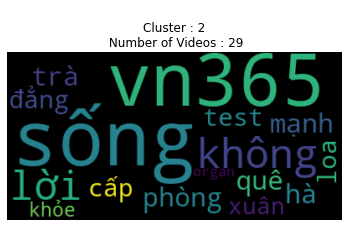

{'sống': 1.0, 'vn365': 0.9565217391304348, 'không': 0.13043478260869565, 'lời': 0.13043478260869565, 'phòng': 0.043478260869565216, 'trà': 0.043478260869565216, 'quê': 0.043478260869565216, 'mạnh': 0.043478260869565216, 'hà': 0.043478260869565216, 'đẳng': 0.043478260869565216, 'cấp': 0.043478260869565216, 'test': 0.043478260869565216, 'loa': 0.043478260869565216, 'xuân': 0.043478260869565216, 'khỏe': 0.043478260869565216, 'organ': 0.043478260869565216}


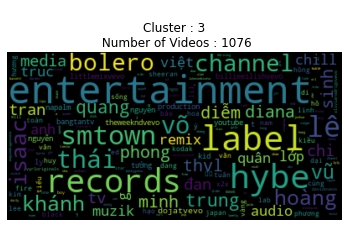

{'entertainment': 1.0, 'label': 0.7692307692307693, 'hybe': 0.7435897435897436, 'records': 0.717948717948718, 'lê': 0.5384615384615384, 'smtown': 0.48717948717948717, 'thái': 0.4358974358974359, 'võ': 0.41025641025641024, 'channel': 0.38461538461538464, 'bolero': 0.38461538461538464, 'isaac': 0.358974358974359, 'khánh': 0.3076923076923077, 'hoàng': 0.3076923076923077, 'vũ': 0.2564102564102564, 'trung': 0.20512820512820512, 'quang': 0.20512820512820512, 'sinh': 0.1794871794871795, 'diễm': 0.1794871794871795, 'minh': 0.1794871794871795, 'thvl': 0.1794871794871795, 'phong': 0.1794871794871795, 'diana': 0.1794871794871795, 'tv': 0.15384615384615385, 'chi': 0.15384615384615385, 'tran': 0.15384615384615385, 'đan': 0.15384615384615385, 'media': 0.15384615384615385, 'truc': 0.1282051282051282, 'chill': 0.1282051282051282, 'anh': 0.1282051282051282, 'g': 0.1282051282051282, 'muzik': 0.1282051282051282, 'lớp': 0.1282051282051282, 'audio': 0.1282051282051282, 'việt': 0.1282051282051282, 'remix': 

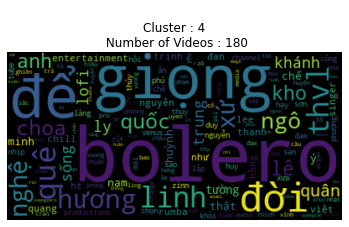

{'bolero': 1.0, 'giọng': 0.9310344827586207, 'để': 0.896551724137931, 'đời': 0.896551724137931, 'quê': 0.4827586206896552, 'thvl': 0.4482758620689655, 'linh': 0.41379310344827586, 'hương': 0.3448275862068966, 'xứ': 0.3103448275862069, 'nghệ': 0.3103448275862069, 'ngô': 0.27586206896551724, 'choa': 0.2413793103448276, 'quốc': 0.2413793103448276, 'lê': 0.20689655172413793, 'anh': 0.20689655172413793, 'kho': 0.20689655172413793, 'quân': 0.20689655172413793, 'khánh': 0.1724137931034483, 'trung': 0.1724137931034483, 'sống': 0.1724137931034483, 'lofi': 0.1724137931034483, 'ly': 0.1724137931034483, 'tường': 0.1724137931034483, 'nam': 0.13793103448275862, 'minh': 0.13793103448275862, 'ý': 0.13793103448275862, 'huỳnh': 0.13793103448275862, 'thật': 0.13793103448275862, 'chế': 0.13793103448275862, 'việt': 0.10344827586206896, 'đan': 0.10344827586206896, 'nguyên': 0.10344827586206896, 'hồng': 0.10344827586206896, 'entertainment': 0.10344827586206896, 'như': 0.10344827586206896, 'singer': 0.1034482

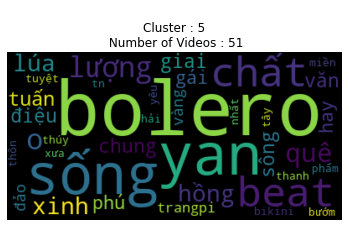

{'bolero': 1.0, 'yan': 0.56, 'sống': 0.52, 'beat': 0.24, 'chất': 0.24, 'lượng': 0.24, 'o': 0.24, 'quê': 0.2, 'hồng': 0.16, 'lúa': 0.16, 'xinh': 0.16, 'tuấn': 0.12, 'chung': 0.12, 'giai': 0.12, 'điệu': 0.12, 'sông': 0.12, 'văn': 0.12, 'phú': 0.12, 'gái': 0.12, 'hay': 0.12, 'đảo': 0.08, 'vàng': 0.08, 'trangpi': 0.08, 'bikini': 0.04, 'yêu': 0.04, 'miền': 0.04, 'tây': 0.04, 'tn': 0.04, 'thanh': 0.04, 'hải': 0.04, 'thôn': 0.04, 'nhất': 0.04, 'thúy': 0.04, 'xưa': 0.04, 'tuyệt': 0.04, 'phẩm': 0.04, 'bướm': 0.04}


In [90]:
for i in range(len(np.unique(label))):
    
    #Extract cleaned text column
    data=abnormal_cluster[abnormal_cluster['label']==i]['channelTitle'].values
    data = removeStopword(data, stopwords)
    list_of_words=[];
    for sent in data:
      if type(sent)!=str:
        continue
      for word in sent.split():
        list_of_words.append(word)  
    final_text=" ".join(list_of_words)
    wordcloud = WordCloud(collocations=False).generate(final_text)
    plt.figure()
    title="\nCluster : "+str(i+1)+"\n Number of Videos : "+str(len(data))
    plt.title(title)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    print(wordcloud.words_)

0


C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_100KView = df[df['viewCount']>=100000][df['viewCount']<1e6]['id']
C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_1MView = df[df['viewCount']>=1e6][df['viewCount']<1e7]['id']
C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_10MView = df[df['viewCount']>=1e7][df['viewCount']<1e8]['id']
C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_100MView = df[df['viewCount']>=1e8][df['viewCount']<1e9]['id']


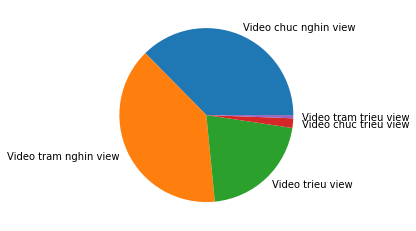

1


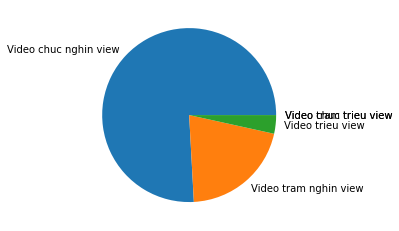

2


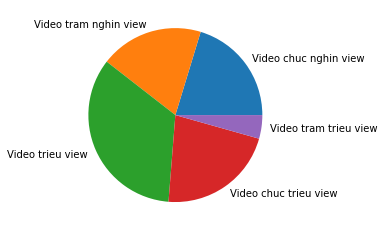

3


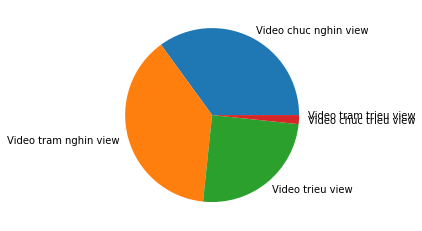

4


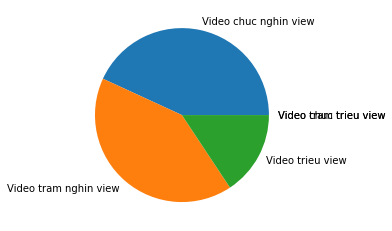

In [84]:
for i in range(len(np.unique(label))):
    print(i)
    pieCharViewCounts(abnormal_cluster[abnormal_cluster['label']==i])

In [87]:
clustered_02_abnormal = abnormal_cluster[abnormal_cluster['label']!=2].sum()
clustered_02_abnormal[['viewCount', 'likeCount', 'durationInt']]

viewCount      994396138
likeCount      7257261.0
durationInt      2442637
dtype: object

In [88]:
clustered_01_abnormal = abnormal_cluster[abnormal_cluster['label']==2].sum()
clustered_01_abnormal[['viewCount', 'likeCount', 'durationInt']]

viewCount      22540015279
likeCount      468590668.0
durationInt         724511
dtype: object

In [ ]:
for item in abnormal_cluster[abnormal_cluster['label']==0]['title']:
    print(item)

Họa Ức - DraTelling x MontEe (Prod. Tuanuki - Animate. SiNo)
Âm Nhạc & Tôi Season 2 - NỬA HỒN THƯƠNG ĐAU | THANH LAN | Liveshow Hải Ngoại Trúc Sinh Entertainment
60S ÂM NHẠC - Búp Bê Trò Chơi Con Mực Squid Game Nhảy Cực Sung cùng Trai Đẹp
[Official MV] RISE ABOVE | TripleD x Mai Âm Nhạc x Mr.Vịt | Yomost VFL Winter 2021 Theme Song
Âm Nhạc & Tôi - NHẠC VŨ TRƯỜNG | Loan Châu, Mỹ Vân | Liveshow Hải Ngoại | Trúc Sinh Entertainment
Ý NIỆM - COLDZY - MAI ÂM NHẠC (LYRICS) RAP VIỆT MÙA 2 TẬP 7 - VÒNG ĐỐI ĐẦU
Âm Nhạc & Tôi, Season 2 | NỖI NIỀM | NHƯ MAI | Live Show Hải Ngoại | Trúc Sinh Entertainment
Âm Nhạc & Tôi - Happy Father’s Day 2021 - "Nhớ Đến Lời Cha” | Trúc Sinh Entertainment
TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm Nhạc | Người Lạ Thoáng Qua, Hẹn Kiếp Sau
Câu chuyện âm nhạc #1 II Cá Heo với âm nhạc II thedien
khi nữ nhạc công phêu cùng âm nhạc và cái kết
KARIK GÂY TRANH CÃI - 2CAN, MAI ÂM NHẠC BỊ LOẠI - SEACHAINS, XÁM TRÌNH DIỄN ĐẲNG CẤP
Âm Nhạc & Tôi, Season 2 | CÔ BÉ DỖI HỜN, 

In [ ]:
print(wordcloud.words_)

{'hồng': 1.0, 'hybe': 0.875, 'labels': 0.875, 'giai': 0.75, 'điệu': 0.75, 'sông': 0.75, 'remix': 0.5, 'sống': 0.25, 'lee': 0.25, 'bangtantv': 0.25, 'vàng': 0.25, 'trữ': 0.25, 'tình': 0.25, 'hoa': 0.25, 'dại': 0.25, 'muzik': 0.25, 'petersounds': 0.125, 'orinn': 0.125, 'thích': 0.125, 'nghe': 0.125, 'huy': 0.125, 'thuỳ': 0.125, 'dung': 0.125, 'bolero': 0.125, 'thái': 0.125, 'quỳnh': 0.125, 'dollypartonvevo': 0.125, "spinnin'": 0.125, 'records': 0.125, 'yang': 0.125, 'tvr': 0.125, 'eltonjohnvevo': 0.125, 'chrisbrownvevo': 0.125, 'alikiba': 0.125, 'mọt': 0.125, 'edm': 0.125, 'mrshin': 0.125, 'chill': 0.125, 'hq': 0.125, 'hậu': 0.125, 'bé': 0.125, "fin'd": 0.125, 'quê': 0.125, 'mình': 0.125, 'tilo': 0.125, 'amp': 0.125, 'theory': 0.125, 'gavin': 0.125, 'magnus': 0.125, 'littlemixvevo': 0.125}
